In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats, linalg
import torch
from fastai.vision.all import *
import image_tabular
import re
import os
import shutil
import stat
import random
from torchvision import models
import timm

In [2]:
train_data = pd.read_csv("C:/worksspace/purr-price-prediction/train.csv")
test_data = pd.read_csv("C:/worksspace/purr-price-prediction/test.csv")

# approach: (1) use only images to predict (2) image combined with tabular data, for this purpose we will use the library image_tabular
# but image-tabular doesn't seem to be maintained anymore
# what is cool down time? 

In [3]:
train_data

,id,price,speed,image
0,7d46fd31038904e2,2.13,Fast (1m),./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,Catatonic (1w),./images/76690b9129b9895c.png
2,c5f9966acce22205,10,Swift (2m),./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2,Catatonic (1w),./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1,Snappy (10m),./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,Fast (1m),./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.3,Swift (2m),./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,Fast (1m),./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.5,Fast (1m),./images/21dd1ee9b54261af.png


In [4]:
train_data.dtypes

id       object
price    object
speed    object
image    object
dtype: object

In [5]:
# firstly, we want to checkout how the speed influences the price (correlation, genral trend)

train_data[train_data["price"].str.contains(",")]

,id,price,speed,image
169,f3d35c91c9326e2f,"1,000,000",Fast (1m),./images/f3d35c91c9326e2f.png
492,d8f329f21806993d,"19,999.995",Swift (2m),./images/d8f329f21806993d.png
1750,8710ef3010f0f6bc,"10,000",Fast (1m),./images/8710ef3010f0f6bc.png
1938,ef35cc81fb7967c3,"15,000",Fast (1m),./images/ef35cc81fb7967c3.png


In [6]:
train_data["price"] = train_data["price"].apply(lambda x : x.replace(",","") if "," in x else x)

In [7]:
train_data[train_data["price"].str.contains(",")]

,id,price,speed,image


In [8]:
train_data["price"] = train_data[("price")].astype(float)

In [9]:
train_data["speed"].unique()

array(['Fast (1m)', 'Catatonic (1w)', 'Swift (2m)', 'Snappy (10m)',
       'Swift (5m)', 'Snappy (30m)', 'Brisk (1h)', 'Slow (16h)',
       'Plodding (4h)', 'Plodding (8h)', 'Brisk (2h)', 'Sluggish (4d)',
       'Sluggish (2d)', 'Slow (24h)'], dtype=object)

In [10]:
# re.search(r"\(([A-Za-z0-9]+)\)", 'Snappy (10m)').group(1)
def get_time(s):
    res_str = re.search(r"\(([A-Za-z0-9]+)\)", s).group(1)
    res = parse_time_string(res_str)
    return res

# we want to convert all time strings to numbers (unit is minute)
def parse_time_string(s):
    items = re.match(r"([0-9]+)([a-z]+)", s, re.I).groups()
    num = int(items[0])
    unit = items[1]
    if "m" in unit:
        return num
    elif "h" in unit:
        return 60 * num
    elif "d" in unit:
        return 60 * 24 * num
    else: # "w"
        return 60 * 24 * 7 * num

In [11]:
stuff = re.match(r"([0-9]+)([a-z]+)", "10m", re.I).groups()
"m" in stuff[1]

True

In [12]:
train_data["speed"] = train_data["speed"].apply(lambda x: get_time(x))

In [13]:
train_data["id"]

0       7d46fd31038904e2
1       76690b9129b9895c
2       c5f9966acce22205
3       dfcbc3748fa8e4ba
4       eefb9c589f2ad43a
              ...       
1995    307a15aebca02b38
1996    9c85020f7a7bdf6b
1997    b02b3492e6b7cd6b
1998    21dd1ee9b54261af
1999    cf63e5026eb6d155
Name: id, Length: 2000, dtype: object

In [14]:
train_data.dtypes

id        object
price    float64
speed      int64
image     object
dtype: object

<AxesSubplot:xlabel='speed', ylabel='Count'>

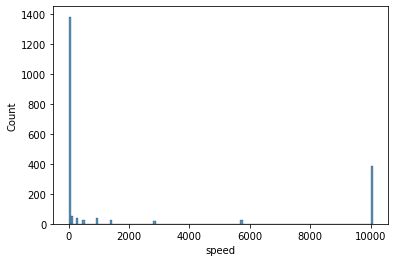

In [15]:
sns.histplot(data=train_data, x="speed")
# when plotting count or density, be careful with continuous data

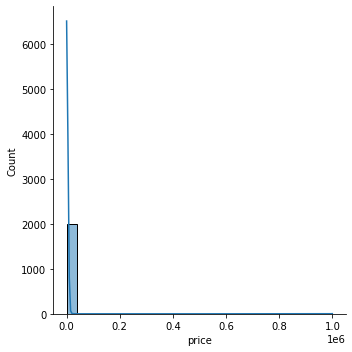

In [16]:
sns.displot(x=train_data["price"], bins=25, kde=True)

<AxesSubplot:xlabel='price'>

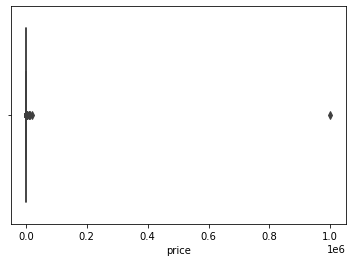

In [17]:
sns.boxplot(x=train_data["price"])

In [18]:
# back up the original data
train_data_original = train_data

In [19]:
train_data_original

,id,price,speed,image
0,7d46fd31038904e2,2.13,1,./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,10080,./images/76690b9129b9895c.png
2,c5f9966acce22205,10.00,2,./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2.00,10080,./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1.00,10,./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,1,./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.30,2,./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,1,./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.50,1,./images/21dd1ee9b54261af.png


In [76]:
train_data = train_data_original

In [71]:
train_data.nlargest(10, ["price"])

,id,price,speed,image
169,f3d35c91c9326e2f,1000000.000,1,./images/f3d35c91c9326e2f.png
492,d8f329f21806993d,19999.995,2,./images/d8f329f21806993d.png
1938,ef35cc81fb7967c3,15000.000,1,./images/ef35cc81fb7967c3.png
1750,8710ef3010f0f6bc,10000.000,1,./images/8710ef3010f0f6bc.png
1258,aa65502de905860e,9999.800,1,./images/aa65502de905860e.png
660,fd7beaca070122de,3999.000,1,./images/fd7beaca070122de.png
766,0d49c6a540d4ebae,2000.000,1,./images/0d49c6a540d4ebae.png
102,1367f467a0378554,1999.000,2,./images/1367f467a0378554.png
1863,8e2b863ae81c563e,1001.000,1,./images/8e2b863ae81c563e.png
351,bc861341b65c5fae,1000.000,1,./images/bc861341b65c5fae.png


In [77]:
train_data = train_data_original.drop(train_data_original[train_data_original["price"] > 200000].index)

In [78]:
train_data

,id,price,speed,image
0,7d46fd31038904e2,2.13,1,./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,10080,./images/76690b9129b9895c.png
2,c5f9966acce22205,10.00,2,./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2.00,10080,./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1.00,10,./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,1,./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.30,2,./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,1,./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.50,1,./images/21dd1ee9b54261af.png


In [79]:
largest_indices = train_data.nlargest(15, ["price"]).index
largest_indices
# just to make it devisible by the batch size (16)

Int64Index([ 492, 1938, 1750, 1258,  660,  766,  102, 1863,  351,  373,  421,
            1050, 1186, 1689, 1930],
           dtype='int64')

In [80]:
train_data = train_data.drop(largest_indices)

In [81]:
train_data

,id,price,speed,image
0,7d46fd31038904e2,2.13,1,./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,10080,./images/76690b9129b9895c.png
2,c5f9966acce22205,10.00,2,./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2.00,10080,./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1.00,10,./images/eefb9c589f2ad43a.png
...,...,...,...,...
1995,307a15aebca02b38,5.08,1,./images/307a15aebca02b38.png
1996,9c85020f7a7bdf6b,0.30,2,./images/9c85020f7a7bdf6b.png
1997,b02b3492e6b7cd6b,1.44,1,./images/b02b3492e6b7cd6b.png
1998,21dd1ee9b54261af,2.50,1,./images/21dd1ee9b54261af.png


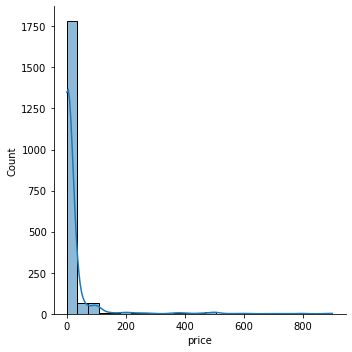

In [82]:
sns.displot(x=train_data["price"], bins=25, kde=True) # afterr removing rows with prices > 25

<AxesSubplot:xlabel='price'>

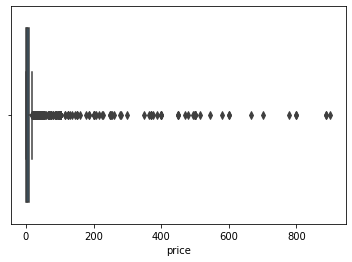

In [83]:
sns.boxplot(x=train_data["price"])

<AxesSubplot:xlabel='speed', ylabel='price'>

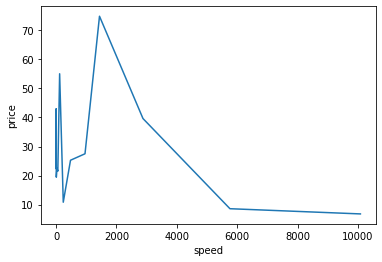

In [84]:
# the relation between speed and price
sns.lineplot(data=train_data, x="speed", y="price", errorbar=None)
# it seems that generally very long cooling time corresponds to lower prices

<AxesSubplot:>

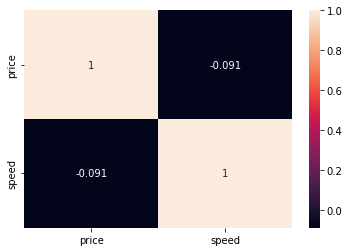

In [85]:
# the correlation matrix ssuggests the same kind of weak correlation
sns.heatmap(train_data.corr(), annot=True)

In [86]:
path = Path("C:\worksspace\purr-price-prediction\images\images")

In [87]:
full_paths_im = get_image_files(path)

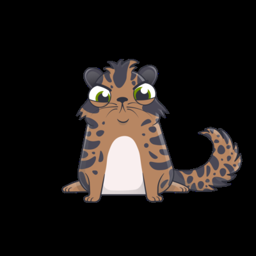

In [88]:
# checkout the first image
Image.open(full_paths_im[0]).to_thumb(256, 256)

In [89]:
# test

first_file_name = full_paths_im[0]
first_file_name

Path('C:/worksspace/purr-price-prediction/images/images/00068810bf2226f2.png')

In [90]:
# test

"png" in first_file_name.name
name_test = os.path.basename("./images/7d46fd31038904e2.png")
train_data.loc[train_data['image'] == "./images/"+name_test, "price"] 

0    2.13
Name: price, dtype: float64

In [91]:
root_path = "C:/worksspace/purr-price-prediction/"

In [92]:
# copy all the images, whose relative row is not removed from the training data
# to a different directory
# also we don't want to edit the original images
root_path = "C:/worksspace/purr-price-prediction/"

if os.listdir(root_path + "images/images_copy/"): # if the directory is not empty

    all_files = os.listdir(root_path + "images/images_copy/")
    
    for f in all_files:
        os.remove(root_path + "images/images_copy/" + f)

# shutil.copyfile(src = root_path + "images/images/7d46fd31038904e2.png", dst = root_path + "images/images_copy/7d46fd31038904e2.png")

In [93]:
# function for getting labels, in our case it's price
def locate_price(filename):
    """
    function locates the price of an image according to the file name of the image
    :param filename: string e.g. '00068810bf2226f2.png'
    :return: 1x1 data frame with the price (float)
    """
    return train_data.loc[train_data['image'] == "./images/"+ filename, "price"] 

def get_price(full_path_im):
    """
    function returns the price of an image according to the full path to the image
    :param full_path_im: Path, e.g. Path('C:/worksspace/purr-price-prediction/images/images/00068810bf2226f2.png')
    :return: float
    """
    filename = os.path.basename(full_path_im.name)
    return float(locate_price(filename))

In [94]:
all_original_files = os.listdir(root_path + "images/images/")

for f in all_original_files:
    if not locate_price(f).empty:
        shutil.copy(src = root_path + "images/images/" + f, dst = root_path + "images/images_copy/" + f)

In [95]:
# check if files are copied correctly
counter = 0
for path in os.scandir("./images/images_copy"):
  if path.is_file:
    counter += 1
counter

1984

In [33]:
# test
locate_price('00068810bf2226f2.png').empty

True

In [34]:


# list(set(random.sample(list(train_data.index), round(num_rows))))

# def splitter(df):
#     num_rows = len(train_data.index)
    
#     num_train = round(num_rows * 0.8)
#     num_valid = num_rows - num_train
    
#     all_indices = list(train_data.index)
    
#     train_indices = list(set(random.sample(list(train_data.index), num_train)))
#     valid_indices = [i for i in all_indices if i not in train_indices]
    
#     return train_indices, valid_indices

In [102]:
dblock = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = get_image_files,
    get_y = get_price,
    splitter = RandomSplitter(),
    item_tfms = Resize(224),
)

In [103]:
path = Path(root_path + "\images\images_copy")
dsets = dblock.datasets(path)

In [104]:
dsets.train[3]

(PILImage mode=RGB size=3000x3000, tensor(1.5000))

In [131]:
dls = dblock.dataloaders(path, bs=16)

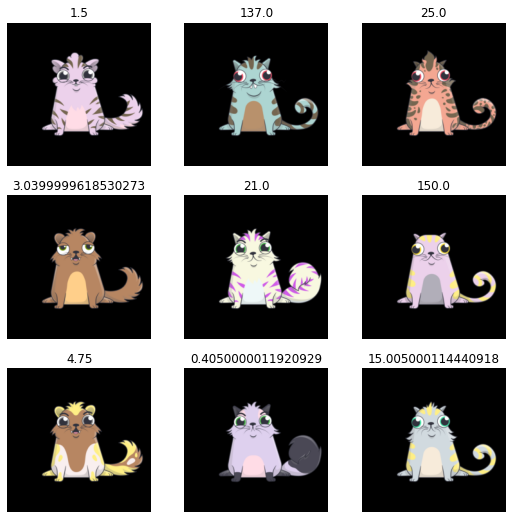

In [132]:
dls.show_batch()

In [107]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

# 64 is the defaut batch size
# dataloader converts the input image to tensor of size [3, 244, 244]

# TODO: deal with the splitter, batch size

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [110]:
dls.c

1

In [51]:
dls.c = 1

In [126]:
rmse

In [133]:
# learn = vision_learner(dls, models.resnet34, y_range=(0, 25))

learn = vision_learner(dls, models.densenet121, y_range=(0, 25), 
                       loss_func = MSELossFlat(),
                       cbs = [GradientClip, MixedPrecision()],
                      metrics = rmse)

In [129]:
learn.metrics

(#1) [<fastai.metrics.AccumMetric object at 0x000001B737682E30>]

In [113]:
learn.loss_func
# FlattenedLoss of MSELoss(): mean squared error loss

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.00363078061491251)

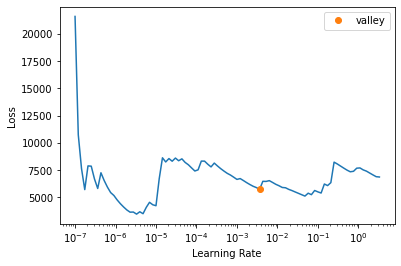

In [134]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=0.00363)

epoch,train_loss,valid_loss,_rmse,time


In [61]:
learn.fine_tune(epochs=3)

epoch,train_loss,valid_loss,time
0,31.429817,30.438858,09:40


epoch,train_loss,valid_loss,time
0,32.219913,30.325201,10:57
1,32.063313,29.785204,10:54
2,34.026505,29.737585,10:43


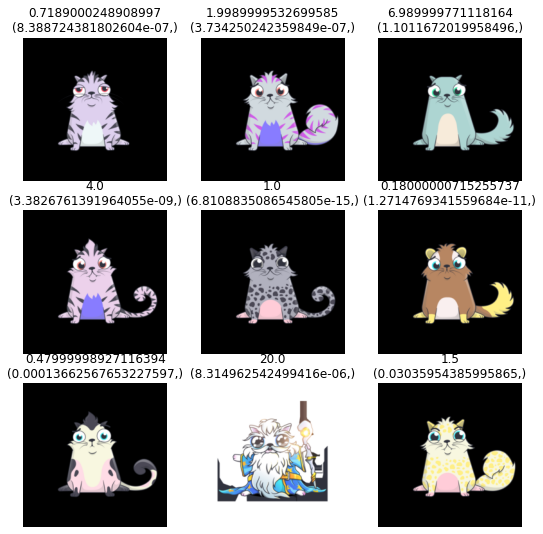

In [62]:
learn.show_results()

In [65]:
test_data

,id,speed,image
0,cb5edc4fbb104b89,Fast (1m),./images/cb5edc4fbb104b89.png
1,1bcef002ce389c49,Slow (24h),./images/1bcef002ce389c49.png
2,bd76ce405ca030f0,Fast (1m),./images/bd76ce405ca030f0.png
3,40553013075ce241,Swift (5m),./images/40553013075ce241.png
4,286049d7edf3ba23,Fast (1m),./images/286049d7edf3ba23.png
...,...,...,...
115,6cf64aa97e47a07b,Catatonic (1w),./images/6cf64aa97e47a07b.png
116,fc6facf81274fc32,Fast (1m),./images/fc6facf81274fc32.png
117,23ce24895ca207a1,Catatonic (1w),./images/23ce24895ca207a1.png
118,64bd0b8e987ac69d,Fast (1m),./images/64bd0b8e987ac69d.png


In [63]:
root_path

'C:/worksspace/purr-price-prediction/'

In [64]:
lst_prices = []

for filename in test_data["image"]:
    filename = os.path.basename(filename)
    # print(filename)
    
    predicted_price = learn.predict(root_path + "images/images/" + filename)
    
    lst_prices.append(float(predicted_price[0][0]))

In [65]:
lst_prices

[1.4196536994859343e-06,
 0.226701021194458,
 7.258639841770662e-16,
 0.037903934717178345,
 0.015174292959272861,
 2.4293188988222525e-12,
 5.099275168785056e-12,
 1.443694053193667e-10,
 4.3269228626741096e-05,
 9.033359726472873e-14,
 1.9823707120281142e-08,
 1.4193128909654372e-17,
 2.6576693926472217e-05,
 6.903606917900429e-13,
 6.180707714520395e-05,
 8.924616601291291e-09,
 0.16747580468654633,
 2.9746698611717557e-16,
 1.6448048256734182e-07,
 2.35150143801377e-09,
 2.173959610555576e-15,
 0.0034933793358504772,
 7.840935366265622e-12,
 0.026691466569900513,
 2.734646464830348e-08,
 8.918110688682646e-05,
 5.6689629554748535,
 1.0693234492320514e-11,
 2.410656690597534,
 0.0007411892293021083,
 0.07493498921394348,
 0.0022813789546489716,
 1.6459077596664429,
 5.638083621306578e-06,
 6.1163647931128384e-12,
 0.12004125118255615,
 2.7648422928905347e-06,
 2.4307249987032264e-05,
 7.228941701969624e-14,
 0.0004166568978689611,
 2.866418853577496e-13,
 1.2350853372260391e-14,
 9.

In [67]:
results = test_data[["id"]]
results = results.assign(price = lst_prices)

In [68]:
results.to_csv(root_path + "results/results.csv", index=False)